In [30]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
from collections import defaultdict
import matplotlib as mpl
from tqdm.notebook import tqdm
# mpl.rcParams['font.family'] = 'Lato'
# Apply the default theme
sns.set_theme(font="Lato")

In [43]:
def _ssim(numpy1, numpy2, dtype='float32', max_val = 1.0):
    import tensorflow as tf
    if dtype == 'float32':
        dtype = tf.float32
    elif dtype == 'uint8':
        dtype = tf.uint8

    img1 = tf.keras.utils.array_to_img(numpy1, data_format=None, scale=True, dtype=None)
    img2 = tf.keras.utils.array_to_img(numpy2, data_format=None, scale=True, dtype=None)
    loss = tf.image.ssim(img1, img2, max_val, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
    return loss 


def if_attack_success(res1, res2, method, **kwargs):
    """
        @param: method: One of: [classification, ssim, ]
    """
    if isinstance(res1, list):
        res1 = np.array(res1)
    if isinstance(res2, list):
        res2 = np.array(res2)
            
    if method == "score":
        divd = 1 
        for a in res1.shape:
            divd *= a 
        # print(kwargs["threshold"])
        res1_new = res1.flatten()
        res2_new = res2.flatten()
        ret1 = np.logical_and(res1_new <= kwargs["threshold"] , res2_new > kwargs["threshold"]) 
        ret2 = np.logical_and(res1_new >= kwargs["threshold"] , res2_new < kwargs["threshold"])
        return 1 - ((np.sum(ret1!=0) + np.sum(ret2 != 0)) / divd)
    elif method == "classification":
        res1 = res1.reshape(res1.shape[0], -1)
        res2 = res2.reshape(res2.shape[0], -1)
        
        # if res1.shape[-1] != 224:
        #     res1 = res1.reshape(-1, res1.shape[-1])
        #     res2 = res2.reshape(-1, res2.shape[-1])
        
        
        # assert len(res1.shape) == 1
        # idx1 = np.unravel_index(res1.argmax(-1),res1.shape)
        # idx2 = np.unravel_index(res2.argmax(-1),res2.shape)
        return np.sum(res1.argmax(-1) != res2.argmax(-1)) / res1.shape[0]
    
    elif method == "ssim":
        loss = _ssim(res1, res2)
        return loss 
    elif method == "segmentation":
        divd = 1 
        for a in res1.shape:
            divd *= a 
        return np.sum((res1 == res2) !=0) / divd
    elif method == "segmentation_argmax":
        res1 = res1.argmax(axis=kwargs['axis'])
        res2 = res2.argmax(axis=kwargs['axis'])
        divd = 1 
        for a in res1.shape:
            divd *= a 
        return np.sum((res1 == res2) !=0) / divd
    elif method == "object_detection":
        print(res1)
    elif method == "euclidean":
        return np.sqrt(np.sum(np.square(res1 - res2)))


In [14]:
path = "/opt/Anonymous/workspace/mob-dl-rev/data/raw/numpys"
apk_paths = []
for dir_name in os.listdir(path):
    apk_paths.append(os.path.join(path, dir_name))
print("APK Counts: {}".format(len(apk_paths)))

APK Counts: 33


In [23]:
model_res_paths = []
tflite_count = 0
tf_count = 0
for apk_path in apk_paths:
    for dir_name in os.listdir(apk_path):
        model_res_paths.append(os.path.join(apk_path, dir_name))
        if dir_name.endswith("tflite"):
            tflite_count += 1
        if dir_name.endswith("pb"):
            tf_count += 1

print("Model Counts: {}".format(len(model_res_paths)))
print("TFLite Model Counts: {}".format(tflite_count))
print("TF Model Counts: {}".format(tf_count))


Model Counts: 102
TFLite Model Counts: 43
TF Model Counts: 59


In [44]:
od_models = [
              "com.shutterfly_2019-07-10/frozen_model_e.pb",
              "ai.fritz.heartbeat_2019-04-25/optimized_inference_graph.pb",
              "apk-faceapp.facemystery.learnmoreaboutyourself/palm_recog_224_1_1.pb",
              "a_i_glass_apkpure.com/detect.tflite",
              "org.prudhvianddheeraj.lite.example.detection/detect.tflite",
              "6b8453244849cec836a149321590d499/object_detect.tflite",
              "com.zuoyebang.airclass/person_detect.tflite",
              "com.zuoyebang.airclass/hand_detect_quantized_model.tflite",
              "4ca5287b7495786b726a099530d6bd63_62611500/lane_detection_v2.2.0_float32.tflite",
              "4ca5287b7495786b726a099530d6bd63_62611500/lane_detection_v2.2.0_noseg_float32.tflite",
              "dae2a8bbd8aa3cc72aa15d9d15f6b1ac_13729700/phoneAndBarCodeDetect_2k_202004160957.tflite",
              "8914ca8f03129b8aca9208bf82bc47c4/detect_model_mobilenetV1_0_5_1280x640.tflite",
              "8914ca8f03129b8aca9208bf82bc47c4/detect_model_mobilenetV1_0_5_1760x800.tflite",
              "net.daum.android.dictionary_2004007/mobilenet_encoder.tflite",
              "dae2a8bbd8aa3cc72aa15d9d15f6b1ac_13729700/tel_recognition_model_4_v3_quant.tflite",
              "com.voltmemo.xz_cidao_350/5000-blackv2-fifty-104x2-plus-long-p96x96-cdraw_model.tflite"
            ]
metric_modes = [
                  ["score", {"threshold":0.5}],
                  ["classification", {}],
                  ["classification", {}],
                  ["classification", {}],
                  ["classification", {}],
                  ["classification", {}],
                  ["classification", {}],
                  ["classification", {}],
                  ["classification", {}],
                  ["classification", {}],
                  ["score", {"threshold":0.5}],
                  ["score", {"threshold":0.5}],
                  ["score", {"threshold":0.5}],
                  ["classification", {}],
                  ["classification", {}],
                  ["classification", {}],
                  # ["score", {"threshold":0.5}]
                ]
base_path = "/opt/Anonymous/workspace/mob-dl-rev/data/raw/numpys/"
od_models = [os.path.join(base_path, x) for x in od_models]

In [34]:
print(len(od_models))

16


In [45]:
sample_names = []
metric_dict = {}

# available_paths = []
# for model_res_path in model_res_paths:
#     if model_res_path in cls_models:
#         print(model_res_path)
#         available_paths.append(model_res_path)

iteration_times = [10, 20]
attack_budgets = [8, 12, 16, 20, 24]

for i in iteration_times:
    for j in attack_budgets:
        metric_dict["{}-{}".format(i, j)] = []



for path, metric_mode in tqdm(zip(od_models, metric_modes), total=len(od_models)):
    # print(path)
    ori_output = {}
    # Find all original output
    for filename in os.listdir(path):
        if "origin" in filename:
            sample_name = filename.split("origin")[0][:-1]
            ori_output[sample_name] = list(np.load(os.path.join(path, filename)).values())[0]
            # print(ori_output[sample_name].shape)
            # break
    
    # Compute Metric
    tmp_dict = defaultdict(lambda: [])
    ori_output_arr = []
    for sample_name in ori_output:
        ori_output_arr.append(ori_output[sample_name])
        for i in iteration_times:
            for j in attack_budgets:
                tmp_name = "{}_{}_{}.npz".format(sample_name, i, j)
                tmp_output = list(np.load(os.path.join(path, tmp_name)).values())[0]
                tmp_dict["{}-{}".format(i, j)].append(tmp_output)
    
    for i in iteration_times:
        for j in attack_budgets:
            tmp = if_attack_success(ori_output_arr, tmp_dict["{}-{}".format(i, j)], method=metric_mode[0], **metric_mode[1])
            metric_dict["{}-{}".format(i, j)].append(tmp)
        

  0%|          | 0/16 [00:00<?, ?it/s]

In [46]:
def cumulative(arr):
    ans = []
    for x in arr:
        if len(ans) == 0:
            ans.append(x)
        else:
            ans.append(ans[-1] + x)
    return ans

budgets = []
iterations = []
metric_data = []

intervals = [(1.0, 0.9), (0.9, 0.8), (0.8, 0.7), (0.7, 0.6), (0.6, 0.5), (0.5, 0.4), (0.4, 0.3), (0.3, 0.2), (0.2, 0.1)]
left_intv = [str(x[1]) for x in intervals]
count_10 = defaultdict(lambda: [0 for _ in range(len(intervals))])
count_20 = defaultdict(lambda: [0 for _ in range(len(intervals))])
print(intervals)

for k in metric_dict:
    i, j = [int(x) for x in k.split("-")]
    if i == 10:
        for x in metric_dict[k]:
            for p, (tmp_left, tmp_right) in enumerate(intervals):
                if x <= tmp_left and x > tmp_right:
                    count_10[j][p] += 1
                    break
    else:
        for x in metric_dict[k]:
            for p, (tmp_left, tmp_right) in enumerate(intervals):
                if x <= tmp_left and x > tmp_right:
                    count_20[j][p] += 1
                    break

model_count = []
eps_arr = []
i = 0
for k in count_10:
    model_count += cumulative(count_10[k])
    eps_arr += [attack_budgets[i]]*len(count_10[k])
    i += 1

i = 0
for k in count_20:
    model_count += cumulative(count_20[k])
    eps_arr += [attack_budgets[i]]*len(count_20[k])
    i += 1


# df = pd.DataFrame({"BUDGETS": budgets, "METRIC":metric_data})
df = pd.DataFrame({"Attack Effect": left_intv*(len(attack_budgets)*2), 
                   "Epsilon": eps_arr, 
                   "Model Count":model_count, 
                   "Attack Iter": [10]*(len(eps_arr)//2) + [20]*(len(eps_arr)//2),
                   "Task": ["Object Detection"]*len(model_count)})


[(1.0, 0.9), (0.9, 0.8), (0.8, 0.7), (0.7, 0.6), (0.6, 0.5), (0.5, 0.4), (0.4, 0.3), (0.3, 0.2), (0.2, 0.1)]


In [21]:
df.loc[df["Attack Effect"]=='0.6'].to_pickle("tmp_files/od-06.pkl")

In [32]:
df = pd.DataFrame({"Attack Effect": left_intv*(len(attack_budgets)*2), 
                   "Epsilon": eps_arr, 
                   "Model Count":model_count, 
                   "Attack Iter": [10]*(len(eps_arr)//2) + [20]*(len(eps_arr)//2)})

/home/Anonymous/anaconda3/envs/mob-dl-rev/lib/python3.9/site-packages/seaborn/axisgrid.py:156: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


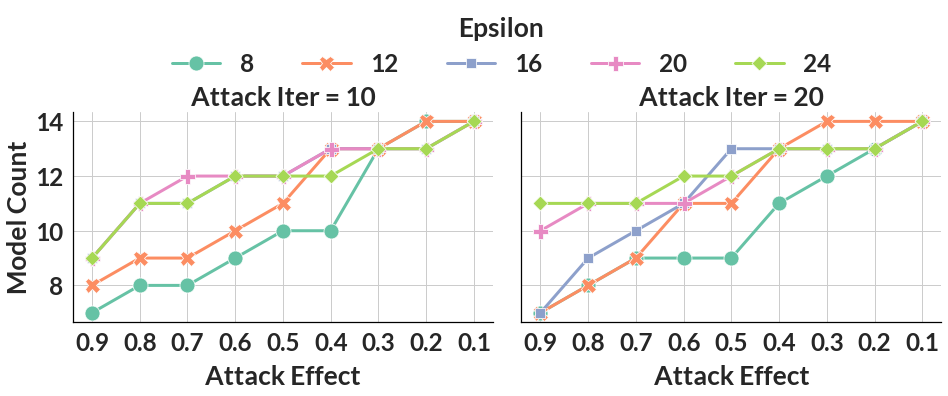

In [47]:
from matplotlib.legend import Legend

sns.set(rc={'figure.figsize':(11.7,8.27), 
            "font.family":"Lato", 
            # "font.style":"italic",
            "font.weight": "bold",
            'axes.edgecolor': 'black',
            "axes.labelweight": "bold",
            "axes.titleweight": "bold",
            "lines.linewidth": 6}, 
        font="Lato", 
        font_scale=2.2, 
        style="whitegrid")

# sns.set_theme()
# hp = sns.histplot(data=df, x="METRIC", hue="BUDGETS", multiple="dodge", shrink=0.8, cumulative=False)
# hp.invert_xaxis()
# hp.cumulative = True
# hp.set_adjustable()
# hp.set_axisbelow(["1.0"])

# bp = sns.barplot(x="Attack Effectiveness", y="Model Count", hue="Epsilon", dodge=True, data=df)

# g = sns.FacetGrid(df, col="Attack Iter")
# g.map(sns.relplot, "Attack Effectiveness", "Model Count", hue="Epsilon", style="Epsilon", dashes=False, markers=True, kind="line", data=df, palette="Set2")


rp = sns.relplot(x="Attack Effect", 
                 y="Model Count", 
                 hue="Epsilon", 
                 style="Epsilon", 
                 col="Attack Iter",
                 dashes=False, markers=True, kind="line", data=df, palette="Set2",
                #  height=6,
                 size=50,
                 legend=False,
                 aspect=1.4,
                 markersize=15)
# bp.invert_xaxis()
# rp.add_legend
rp.add_legend(bbox_to_anchor=(0.31, 1.14), 
              loc='upper center', 
              ncol=5, 
              title="Epsilon", 
              labels=["8", "12", "16", "20", "24"],
              borderaxespad=0)
rp.axes[0][0].xaxis.labelpad = 10
rp.axes[0][1].xaxis.labelpad = 10
rp.tight_layout()

In [ ]:
rp.figure.savefig("./output_figure/od-pgd-res.pdf", dpi=600, bbox_inches="tight")